> # 動的計画法を用いて価値関数を求める

> # 価値関数の定義

$$
    v_\pi(s) = \mathbf{E}_\pi [R_t + \lambda R_{t+1} + \lambda^2 R_{t+2} + \cdots | S_t = s]
$$

$ v_\pi(s)$ : 状態sでの価値関数 </br>
$ R_t $ : 時刻tでの環境からの報酬 </br>
$ \lambda $ : 割引率（0から1）</br>
$ S_t = s $ : 時刻tでの環境（条件をつける） 


このままでは無限和を計算できないので、次のベルマン方程式を使用する。

> # ベルマン方程式

$$
    v_\pi(s) = \sum_{a, s'} \pi (a|s) p(s'|s, a) \bigg\{ r(s, a, s') + \lambda V_\pi(s') \bigg\}
$$

$ \pi (a|s)$ : 状態sの下で、ある行動aを選ぶ確率（方策）</br>
$ p(s'|s, a) $ : 状態sである行動aを選んだ下で、次にある状態$s'$に遷移する確率（状態遷移確率）</br>
$ r(s, a, s') $ : 状態sである行動aを選び、次にある状態$s'$に遷移した時に、エージェントが受け取る報酬（報酬関数）

ベルマン方程式を次の「更新式」へと変形することで、強化学習アルゴリズムとして実装する。

> ## ベルマン方程式（更新式バージョン）

$$
    v_{k+1}(s) = \sum_{a, s'} \pi (a|s) p(s'|s, a) \bigg\{ r(s, a, s') + \lambda V_k(s') \bigg\}
$$

$V_{k+1}(s), V_k(s)$はそれぞれ$k+1, k$回目に更新された価値関数を表す。**それぞれ推測値であり、真の価値関数とは異なる**ことに注意。

推定値を使用して別の推定値を改善するプロセスを、「ブートストラッピング(Bootstraping)」という。

> ## 状態遷移が決定論的な場合

$$
    v_{k+1}(s) = \sum_{a} \pi (a|s)  \bigg\{ r(s, a, s') + \lambda V_k(s') \bigg\}
$$

少し簡略化される。これを2状態の系（L1、L2の二つのコマを持つ2マスのグリッドワールド）に対して実装する。

In [2]:
# 簡単な価値関数の計算の実装
# 状態が2状態、状態遷移が決定論的な場合
# エージェントが右に行く確率を0.5, 左に行く確率を0.5とする。
# L1から左、L2から右に行く場合は壁が存在するものとし、同じ場所にとどまるものとする。
# エージェントはL2に辿り着くと+1、壁にぶつかると-1の報酬を得る。

V = {'L1' : 0.0, 'L2' : 0.0}

count = 0

while True:
    # 時刻k+1で状態L1にいるときの価値関数
    t = 0.5 * (-1 + 0.9 * V['L1']) + 0.5 * (1 + 0.9 * V['L2'])
    delta = abs(t - V['L1'])    # 自動ストップ用
    V['L1'] = t
    
    # 時刻k+1で状態L2にいるときの価値関数
    t = 0.5 * (0 + 0.9 * V['L1']) + 0.5 * (-1 + 0.9 * V['L2'])
    delta = max(delta, abs(t - V['L2']))
    V['L2'] = t
    
    count += 1
    
    if delta < 0.0001:
        print(f"それぞれの状態での価値関数の計算結果 : {V}")
        print(f"繰り返し回数 : {count}")
        break

それぞれの状態での価値関数の計算結果 : {'L1': -2.2493782177156936, 'L2': -2.7494201578106514}
繰り返し回数 : 60


> # より大きな問題への適用

<img src='image/gridworld.jpeg' width=50% height=50%>

> ### 設定
* エージェントは4方向に進むことができる。
* 灰色の部分と、壁（グリッドワールドの外側）には進むことができない。
* 壁にぶつかった場合の報酬は0。りんごは+1、爆弾は-1。
* 環境の状態遷移は一意に決まるとする。例えば、エージェントが右に行く行動を選択すると、環境の状態によらず必ず右に進む。
* 今回のタスクはエピソードタスクとし、りんごをとったら終了。

In [3]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt


class Renderer:
    def __init__(self, reward_map, goal_state, wall_state):
        self.reward_map = reward_map
        self.goal_state = goal_state
        self.wall_state = wall_state
        self.ys = len(self.reward_map)
        self.xs = len(self.reward_map[0])

        self.ax = None
        self.fig = None
        self.first_flg = True

    def set_figure(self, figsize=None):
        fig = plt.figure(figsize=figsize)
        self.ax = fig.add_subplot(111)
        ax = self.ax
        ax.clear()
        ax.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)
        ax.set_xticks(range(self.xs))
        ax.set_yticks(range(self.ys))
        ax.set_xlim(0, self.xs)
        ax.set_ylim(0, self.ys)
        ax.grid(True)

    def render_v(self, v=None, policy=None, print_value=True):
        self.set_figure()

        ys, xs = self.ys, self.xs
        ax = self.ax

        if v is not None:
            color_list = ['red', 'white', 'green']
            cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
                'colormap_name', color_list)

            # dict -> ndarray
            v_dict = v
            v = np.zeros(self.reward_map.shape)
            for state, value in v_dict.items():
                v[state] = value

            vmax, vmin = v.max(), v.min()
            vmax = max(vmax, abs(vmin))
            vmin = -1 * vmax
            vmax = 1 if vmax < 1 else vmax
            vmin = -1 if vmin > -1 else vmin

            ax.pcolormesh(np.flipud(v), cmap=cmap, vmin=vmin, vmax=vmax)

        for y in range(ys):
            for x in range(xs):
                state = (y, x)
                r = self.reward_map[y, x]
                if r != 0 and r is not None:
                    txt = 'R ' + str(r)
                    if state == self.goal_state:
                        txt = txt + ' (GOAL)'
                    ax.text(x+.1, ys-y-0.9, txt)

                if (v is not None) and state != self.wall_state:
                    if print_value:
                        offsets = [(0.4, -0.15), (-0.15, -0.3)]
                        key = 0
                        if v.shape[0] > 7: key = 1
                        offset = offsets[key]
                        ax.text(x+offset[0], ys-y+offset[1], "{:12.2f}".format(v[y, x]))

                if policy is not None and state != self.wall_state:
                    actions = policy[state]
                    max_actions = [kv[0] for kv in actions.items() if kv[1] == max(actions.values())]

                    arrows = ["↑", "↓", "←", "→"]
                    offsets = [(0, 0.1), (0, -0.1), (-0.1, 0), (0.1, 0)]
                    for action in max_actions:
                        arrow = arrows[action]
                        offset = offsets[action]
                        if state == self.goal_state:
                            continue
                        ax.text(x+0.45+offset[0], ys-y-0.5+offset[1], arrow)

                if state == self.wall_state:
                    ax.add_patch(plt.Rectangle((x,ys-y-1), 1, 1, fc=(0.4, 0.4, 0.4, 1.)))
        plt.show()

    def render_q(self, q, show_greedy_policy=True):
        self.set_figure()

        ys, xs = self.ys, self.xs
        ax = self.ax
        action_space = [0, 1, 2, 3]

        qmax, qmin = max(q.values()), min(q.values())
        qmax = max(qmax, abs(qmin))
        qmin = -1 * qmax
        qmax = 1 if qmax < 1 else qmax
        qmin = -1 if qmin > -1 else qmin


        color_list = ['red', 'white', 'green']
        cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
            'colormap_name', color_list)

        for y in range(ys):
            for x in range(xs):
                for action in action_space:
                    state = (y, x)
                    r = self.reward_map[y, x]
                    if r != 0 and r is not None:
                        txt = 'R ' + str(r)
                        if state == self.goal_state:
                            txt = txt + ' (GOAL)'
                        ax.text(x+.05, ys-y-0.95, txt)

                    if state == self.goal_state:
                        continue

                    tx, ty = x, ys-y-1

                    action_map = {
                        0: ((0.5+tx, 0.5+ty), (tx+1, ty+1), (tx, ty+1)),
                        1: ((tx, ty), (tx+1, ty), (tx+0.5, ty+0.5)),
                        2: ((tx, ty), (tx+0.5, ty+0.5), (tx, ty+1)),
                        3: ((0.5+tx, 0.5+ty), (tx+1, ty), (tx+1, ty+1)),
                    }
                    offset_map = {
                        0: (0.1, 0.8),
                        1: (0.1, 0.1),
                        2: (-0.2, 0.4),
                        3: (0.4, 0.4),
                    }
                    if state == self.wall_state:
                        ax.add_patch(plt.Rectangle((tx, ty), 1, 1, fc=(0.4, 0.4, 0.4, 1.)))
                    elif state in self.goal_state:
                        ax.add_patch(plt.Rectangle((tx, ty), 1, 1, fc=(0., 1., 0., 1.)))
                    else:

                        tq = q[(state, action)]
                        color_scale = 0.5 + (tq / qmax) / 2  # normalize: 0.0-1.0

                        poly = plt.Polygon(action_map[action],fc=cmap(color_scale))
                        ax.add_patch(poly)

                        offset= offset_map[action]
                        ax.text(tx+offset[0], ty+offset[1], "{:12.2f}".format(tq))
        plt.show()

        if show_greedy_policy:
            policy = {}
            for y in range(self.ys):
                for x in range(self.xs):
                    state = (y, x)
                    qs = [q[state, action] for action in range(4)]  # action_size
                    max_action = np.argmax(qs)
                    probs = {0:0.0, 1:0.0, 2:0.0, 3:0.0}
                    probs[max_action] = 1
                    policy[state] = probs
            self.render_v(None, policy)

In [4]:
# GridWorld クラスの実装
# 先ほどの絵の左上が(0, 0)
import numpy as np

class GridWorld:
    def __init__(self):
        # 行動できる方向を指定（4つ）
        self.action_space = [0, 1, 2, 3]
        # 各状態の数字に行動の「意味」をつける
        self.action_meaning = {
            0: 'UP',
            1: 'DOWN',
            2: 'LEFT',
            3: 'RIGHT',
        }
        
        # マップを与える
        self.reward_map = np.array(
            [[0, 0, 0, 1.0],
             [0, None, 0, -1.0],
             [0, 0, 0, 0]]
        )
        
        # 特殊な状態となる場所を定義
        self.goal_state = (0, 3)
        self.wall_state = (1, 1)
        self.start_state = (2, 0)
        
        # エージェントの開始位置
        self.agent_state = self.start_state
        
        
    @property
    def height(self):
        return len(self.reward_map)
        
    @property
    def width(self):
        return len(self.reward_map[0])
        
    @property
    def shape(self):
        return self.reward_map.shape
        
    def actions(self):
        return self.action_space    # [0, 1, 2, 3]
        
    def states(self):
        for h in range(self.height):
            for w in range(self.width):
                yield (h, w)
                
            
    def next_state(self, state, action):
        action_move_map = [(-1, 0), (1, 0), (0, -1), (0, 1)]
        move = action_move_map[action]
        next_state = (state[0] + move[0], state[1] + move[1])
        ny, nx = next_state

        if nx < 0 or nx >= self.width or ny < 0 or ny >= self.height:
            next_state = state
        elif next_state == self.wall_state:
            next_state = state

        return next_state

    def reward(self, state, action, next_state):
        return self.reward_map[next_state]

    def reset(self):
        self.agent_state = self.start_state
        return self.agent_state

    def step(self, action):
        state = self.agent_state
        next_state = self.next_state(state, action)
        reward = self.reward(state, action, next_state)
        done = (next_state == self.goal_state)

        self.agent_state = next_state
        return next_state, reward, done

    def render_v(self, v=None, policy=None, print_value=True):
        renderer = Renderer(self.reward_map, self.goal_state,
                                          self.wall_state)
        renderer.render_v(v, policy, print_value)

    def render_q(self, q=None, print_value=True):
        renderer = Renderer(self.reward_map, self.goal_state,
                                          self.wall_state)
        renderer.render_q(q, print_value)


In [5]:
# propertyで小レータを使用すると、メソッドをインスタンス変数として使用できる。

env = GridWorld()

# env.height()ではなく、env.heightとして使用できる。

print(env.height)   # 3

3


In [6]:
# actions, stateメソッドを使うと全ての行動、全ての状態に順にアクセスできる
for action in env.actions():
    print(action)
    
print('======')
for state in env.states():
    print(state)

0
1
2
3
(0, 0)
(0, 1)
(0, 2)
(0, 3)
(1, 0)
(1, 1)
(1, 2)
(1, 3)
(2, 0)
(2, 1)
(2, 2)
(2, 3)


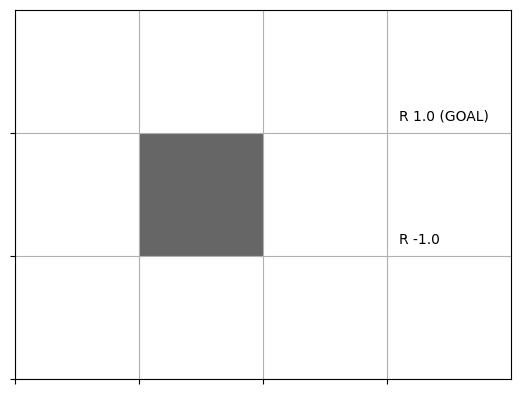

In [7]:
# グリッドワールドを表示する
env = GridWorld()
env.render_v()

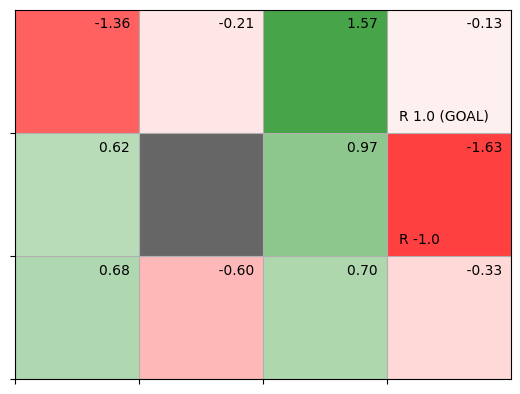

In [8]:
# 価値関数の値をテスト表示してみる
V = {}
for state in env.states():
    V[state] = np.random.randn()    # ダミーの状態関数
env.render_v(V)

> # 反復方策評価の実装

反復豊作評価アルゴリズムの式
$s' = f(s,a)$（決定論的）として、

$$
    V_{k+1} (s) = \sum_{a}\pi(a|s) \bigg\{ r(s,a,s') + \gamma V_k(s') \bigg\}
$$

に代入

In [9]:
def eval_onestep(pi, V, env, gamma=0.9):
    for state in env.states():  # 1.各状態へアクセス
        if state == env.goal_state: # 2.ゴールの価値関数は常に0
            V[state] = 0
            continue
    
        action_prob = pi[state] 
        new_V = 0
    
        # 3.各行動へアクセス
        for action, action_prob in action_prob.items():
            next_state = env.next_state(state, action)
            r = env.reward(state, action, next_state)
            # 4.新しい価値関数を計算
            new_V += action_prob * (r + gamma * V[next_state])
        V[state] = new_V
    return V

def policy_eval(pi, V, env, gamma, threshold=0.0001):
    while True:
        old_V = V.copy()    # 更新前の価値関数
        V = eval_onestep(pi, V, env, gamma)
        
        # 更新された量の最大値を求める
        delta = 0
        for state in V.keys():
            t = abs(V[state] - old_V[state])
            if delta < t:
                delta = t
                
        # 閾値との比較
        if delta < threshold:
            break
    return V

> # 方策評価を行なう

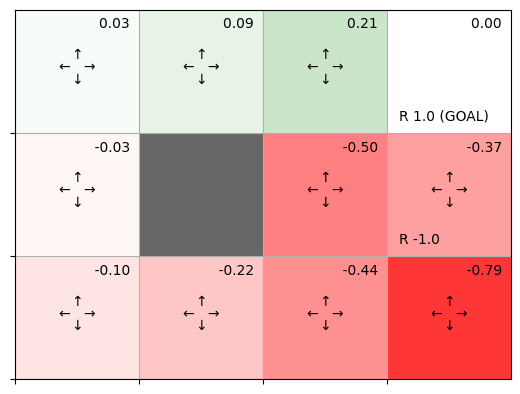

In [10]:
from collections import defaultdict

env = GridWorld()
gamma = 0.9

pi = defaultdict(lambda: {0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25})

V = defaultdict(lambda: 0)

V = policy_eval(pi, V, env, gamma)
env.render_v(V, pi)

> # 方策反復法

> ## 4.4 最適方策

$$
    \mu_* (s) = \argmax_a q_* (s, a)\\
              = \argmax_a \sum_{s'} p(s'|s,a)\bigg\{ r(s, a, s') + \gamma v_*(s') \bigg\}
$$

最適な方策は、最大値を取る行動aによって決まる。$\argmax_a$による演算は、局所的な候補から最善となる行動を決める。</br>
→「Greedyな方策」

価値関数$q_*(s,a)$は、状態sと行動aの関数であることに注意。

> # 4.4.1 方策の改善

方策を改善するには、現状の価値関数に対してgreedyな方策を得る。数式で書くと、

$$
    \mu'(x) = \argmax_a \sum_{s'} p(s'|s, a) \bigg\{ r(s, a, s') + \gamma v_\mu (s') \bigg\}
$$

今回は状態遷移は決定論的であるとして、

$$
    \mu'(x) = \argmax_a  \bigg\{ r(s, a, s') + \gamma v_\mu (s') \bigg\}
$$

In [15]:
# argmax
def argmax(d):
    max_value = max(d.values())
    max_key = 0
    for key, value in d.items():
        if value == max_value:
            max_key = key
    
    return max_key

In [12]:
# 価値関数をgreedy化する関数
def greedy_policy(V, env, gamma):
    pi = {}
    
    for state in env.states():
        action_values = {}
        
        for action in env.actions():
            next_state = env.next_state(state, action)
            r = env.reward(state, action, next_state)
            value = r + gamma * V[next_state]   # 1.価値関数を計算
            action_values[action] = value
            
        max_action = argmax(action_values)  # 2.最大の価値関数を持つ行動を取り出す
        action_probs = {0:0, 1:0, 2:0, 3:0}
        action_probs[max_action] = 1.0  # 3. 価値関数が最大となる行動が選ばれる確率を100%にする
        pi[state] = action_probs    # 4. 状態stateにおける行動の確率分布に設定
    
    return pi

> # 4.4.2 評価と改善を繰り返す

In [23]:
# 方策反復法を実装
def policy_iter(env, gamma, threshold=0.001, is_render=False):
    pi = defaultdict(lambda: {0:0.25, 1:0.25, 2:0.25, 3:0.25})
    V = defaultdict(lambda:0)
    
    while True:
        V = policy_eval(pi, V, env, gamma, threshold)   # 1. 現状の方策を用いて価値関数を評価
        new_pi = greedy_policy(V, env, gamma)   # 2. 価値関数を最大にするように方策をgreedy化
        
        if is_render:
            env.render_v(V, pi)
        
        if new_pi == pi:    # 3. 方策が更新されたかチェック（更新されていなければベルマン最適方程式を満たしているのでループを抜ける）
            break
        pi = new_pi
        

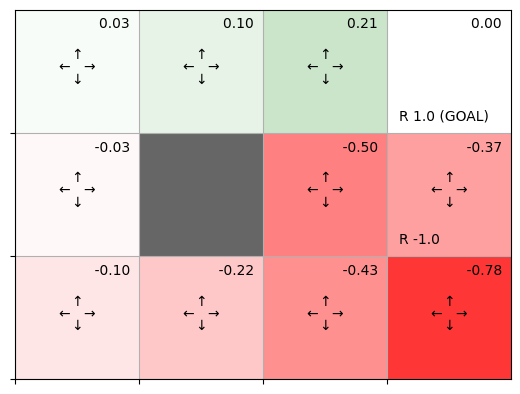

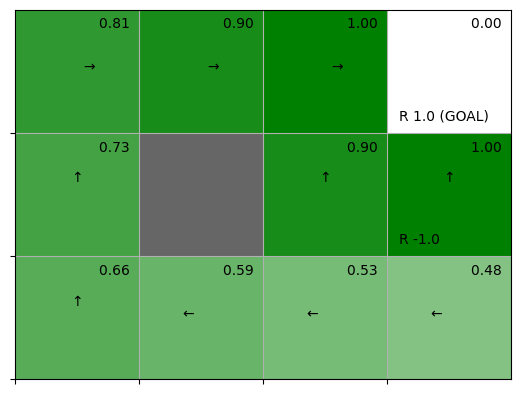

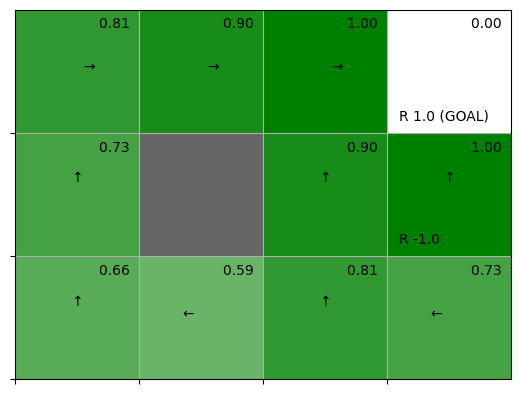

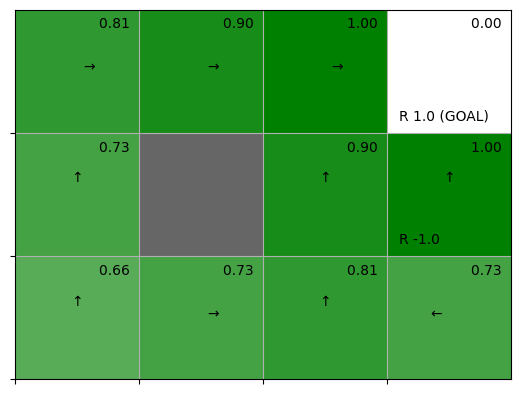

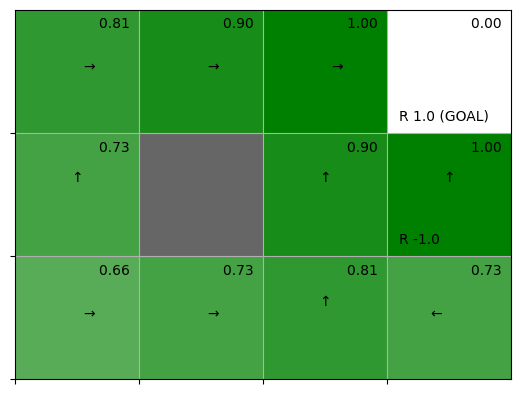

In [24]:
env = GridWorld()
gamma = 0.9

pi = policy_iter(env, gamma, is_render=True)